['4282.jpg', '1704.jpg', '2333.jpg', '2320.jpg', '1680.jpg', '2120.jpg', '3291.jpg', '0393.jpg', '0160.jpg', '3041.jpg', '1374.jpg', '5388.jpg', '3683.jpg', '1052.jpg', '1454.jpg', '2560.jpg', '4124.jpg', '1334.jpg', '5710.jpg', '5256.jpg', '2398.jpg', '5860.jpg', '5230.jpg', '3131.jpg', '2941.jpg', '2696.jpg', '5137.jpg', '5550.jpg', '0513.jpg', '0467.jpg', '0286.jpg', '4749.jpg', '2386.jpg', '2238.jpg', '5545.jpg', '1296.jpg', '4366.jpg', '2404.jpg', '4535.jpg', '1238.jpg', '0836.jpg', '2469.jpg', '2375.jpg', '3204.jpg', '0644.jpg', '4568.jpg', '1758.jpg', '2348.jpg', '4919.jpg', '1868.jpg', '5336.jpg', '3737.jpg', '4419.jpg', '0814.jpg', '5871.jpg', '3317.jpg', '3976.jpg', '4075.jpg', '4766.jpg', '3445.jpg', '0869.jpg', '2005.jpg', '3705.jpg', '0091.jpg', '3630.jpg', '2309.jpg', '2974.jpg', '1601.jpg', '3901.jpg', '5428.jpg', '0383.jpg', '0864.jpg', '1381.jpg', '5874.jpg', '4092.jpg', '5367.jpg', '2315.jpg', '2172.jpg', '2363.jpg', '3648.jpg', '4946.jpg', '2336.jpg', '0933.jpg', '25

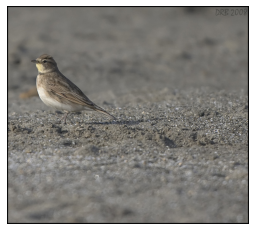

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, glob, time, copy, random, zipfile
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
    
classes = list()
with open('./2021VRDL_HW1_datasets/classes.txt') as f:
   for line in f:
       # For Python3, use print(line)
        classes.append(line[:-1])
        if 'str' in line:
            break
# print(classes)

testorder = list()
with open('./2021VRDL_HW1_datasets/testing_img_order.txt') as f:
   for line in f:
       # For Python3, use print(line)
        testorder.append(line.split('\n')[0])
        if 'str' in line:
            break
print(testorder)


os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
torch.cuda.empty_cache()

test_dir = './2021VRDL_HW1_datasets/testing_images'

test_list = glob.glob(os.path.join(test_dir, '*.jpg'))


img = Image.open(test_list[0])
plt.imshow(img)
plt.axis('off')
plt.show()



In [2]:
class ImageTransform():
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'test': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [3]:
label_dict = {}
with open('./2021VRDL_HW1_datasets/training_labels.txt', 'r', encoding='utf-8-sig') as R:
    lines = R.readlines()
for line in lines:
    line = line.split('\n')[0].split(" ")
    label_dict[line[0]] = (line[1])
#     print (line)
label_dict

{'4283.jpg': '115.Brewer_Sparrow',
 '3982.jpg': '162.Canada_Warbler',
 '5836.jpg': '144.Common_Tern',
 '5980.jpg': '008.Rhinoceros_Auklet',
 '4168.jpg': '161.Blue_winged_Warbler',
 '2352.jpg': '061.Heermann_Gull',
 '0511.jpg': '038.Great_Crested_Flycatcher',
 '4492.jpg': '147.Least_Tern',
 '1254.jpg': '132.White_crowned_Sparrow',
 '2792.jpg': '177.Prothonotary_Warbler',
 '1171.jpg': '098.Scott_Oriole',
 '3741.jpg': '062.Herring_Gull',
 '5751.jpg': '030.Fish_Crow',
 '3819.jpg': '081.Pied_Kingfisher',
 '0082.jpg': '041.Scissor_tailed_Flycatcher',
 '4532.jpg': '102.Western_Wood_Pewee',
 '2452.jpg': '091.Mockingbird',
 '5231.jpg': '101.White_Pelican',
 '2412.jpg': '171.Myrtle_Warbler',
 '1183.jpg': '091.Mockingbird',
 '1969.jpg': '097.Orchard_Oriole',
 '2772.jpg': '045.Northern_Fulmar',
 '5952.jpg': '121.Grasshopper_Sparrow',
 '2466.jpg': '164.Cerulean_Warbler',
 '5964.jpg': '160.Black_throated_Blue_Warbler',
 '5558.jpg': '035.Purple_Finch',
 '1448.jpg': '169.Magnolia_Warbler',
 '1338.jpg'

In [4]:
test_list[0].split('\\')[-1]
test_list

['./2021VRDL_HW1_datasets/testing_images\\0001.jpg',
 './2021VRDL_HW1_datasets/testing_images\\0002.jpg',
 './2021VRDL_HW1_datasets/testing_images\\0004.jpg',
 './2021VRDL_HW1_datasets/testing_images\\0005.jpg',
 './2021VRDL_HW1_datasets/testing_images\\0006.jpg',
 './2021VRDL_HW1_datasets/testing_images\\0007.jpg',
 './2021VRDL_HW1_datasets/testing_images\\0009.jpg',
 './2021VRDL_HW1_datasets/testing_images\\0015.jpg',
 './2021VRDL_HW1_datasets/testing_images\\0016.jpg',
 './2021VRDL_HW1_datasets/testing_images\\0020.jpg',
 './2021VRDL_HW1_datasets/testing_images\\0021.jpg',
 './2021VRDL_HW1_datasets/testing_images\\0022.jpg',
 './2021VRDL_HW1_datasets/testing_images\\0024.jpg',
 './2021VRDL_HW1_datasets/testing_images\\0025.jpg',
 './2021VRDL_HW1_datasets/testing_images\\0026.jpg',
 './2021VRDL_HW1_datasets/testing_images\\0028.jpg',
 './2021VRDL_HW1_datasets/testing_images\\0030.jpg',
 './2021VRDL_HW1_datasets/testing_images\\0033.jpg',
 './2021VRDL_HW1_datasets/testing_images\\0034

In [5]:
# Dataset
class PartDataset(data.Dataset):
    
    def __init__(self, label_dict, file_list, transform=None, phase='train'):
        self.label_dict = label_dict
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert('RGB')
        
        img_transformed = self.transform(img, self.phase)
        # Get Label
#         label = self.label_dict[img_path.split('\\')[-1]]
        return img_transformed, ''

In [6]:
size = 224
norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225)
# norm_mean = [0.5, 0.5, 0.5]
# norm_std = [0.5, 0.5, 0.5]

batch_size = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
test_dataset = PartDataset(label_dict, test_list, transform=ImageTransform(size, mean, std), phase='test')

In [8]:
test_dataloader = data.DataLoader(test_dataset, batch_size=4, shuffle=False)

dataiter = iter(test_dataloader)
images, labels = dataiter.next()

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 201)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
test_list[0].replace('\\','/')

'./2021VRDL_HW1_datasets/testing_images/0001.jpg'

In [11]:
# config
vis = True
# vis = False
vis_row = 4

norm_mean = [0.5, 0.5, 0.5]
norm_std = [0.5, 0.5, 0.5]

inference_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

resnet50 =models.resnet50( pretrained=True).to(device)

# 修改全连接层的输出
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 200)

# 加载模型参数
checkpoint = resnet50.load_state_dict(torch.load('./2021VRDL_HW1_datasets/best_checkpoint_new.pth', map_location='cpu'))


In [12]:
resnet50.to(device)
resnet50.eval()



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
def img_transform(img_rgb, transform=None):


    if transform is None:
        raise ValueError("")

    img_t = transform(img_rgb)
    return img_t

In [14]:
import time
path = 'answer.txt'
f = open(path, 'w')

with torch.no_grad():
#         print(classes)
        for  img_name in testorder:
            print(img_name)
            path_img ='./2021VRDL_HW1_datasets/testing_images\\'+img_name
            img_rgb = Image.open(path_img).convert('RGB')

            img_tensor = img_transform(img_rgb, inference_transform)
            img_tensor.unsqueeze_(0)
            img_tensor = img_tensor.to(device)
            
            # step 3/4 : tensor --> vector
            time_tic = time.time()
            outputs = resnet50(img_tensor)
            time_toc = time.time()
            
             # step 4/4 : visualization
            _, pred_int = torch.max(outputs.data, 1)
#             print(int(pred_int))
#             print(classes[int(pred_int)])
            pred_str = classes[int(pred_int)]
        
            f.write(img_name)           
            f.write(' ')
            f.write(pred_str)  
            f.write('\n')
            
f.close()

4282.jpg
1704.jpg
2333.jpg
2320.jpg
1680.jpg
2120.jpg
3291.jpg
0393.jpg
0160.jpg
3041.jpg
1374.jpg
5388.jpg
3683.jpg
1052.jpg
1454.jpg
2560.jpg
4124.jpg
1334.jpg
5710.jpg
5256.jpg
2398.jpg
5860.jpg
5230.jpg
3131.jpg
2941.jpg
2696.jpg
5137.jpg
5550.jpg
0513.jpg
0467.jpg
0286.jpg
4749.jpg
2386.jpg
2238.jpg
5545.jpg
1296.jpg
4366.jpg
2404.jpg
4535.jpg
1238.jpg
0836.jpg
2469.jpg
2375.jpg
3204.jpg
0644.jpg
4568.jpg
1758.jpg
2348.jpg
4919.jpg
1868.jpg
5336.jpg
3737.jpg
4419.jpg
0814.jpg
5871.jpg
3317.jpg
3976.jpg
4075.jpg
4766.jpg
3445.jpg
0869.jpg
2005.jpg
3705.jpg
0091.jpg
3630.jpg
2309.jpg
2974.jpg
1601.jpg
3901.jpg
5428.jpg
0383.jpg
0864.jpg
1381.jpg
5874.jpg
4092.jpg
5367.jpg
2315.jpg
2172.jpg
2363.jpg
3648.jpg
4946.jpg
2336.jpg
0933.jpg
2545.jpg
4582.jpg
1711.jpg
3133.jpg
5312.jpg
0719.jpg
2179.jpg
4517.jpg
0772.jpg
4806.jpg
2691.jpg
1965.jpg
4966.jpg
3566.jpg
4123.jpg
3502.jpg
4555.jpg
3923.jpg
1437.jpg
1230.jpg
4829.jpg
2512.jpg
4391.jpg
2349.jpg
0040.jpg
2551.jpg
3888.jpg
2935.jpg
0

4693.jpg
4099.jpg
2240.jpg
4074.jpg
4236.jpg
5376.jpg
4200.jpg
1774.jpg
6004.jpg
4974.jpg
2356.jpg
3672.jpg
4605.jpg
2346.jpg
1512.jpg
0561.jpg
4889.jpg
5212.jpg
4552.jpg
4417.jpg
2373.jpg
4722.jpg
5708.jpg
2608.jpg
3463.jpg
3507.jpg
4114.jpg
0435.jpg
2056.jpg
5355.jpg
2658.jpg
2087.jpg
5742.jpg
2909.jpg
4131.jpg
2040.jpg
2808.jpg
0894.jpg
3099.jpg
4381.jpg
3829.jpg
2438.jpg
3597.jpg
5935.jpg
4891.jpg
5727.jpg
1968.jpg
3377.jpg
0859.jpg
5532.jpg
2566.jpg
2378.jpg
5168.jpg
3125.jpg
3760.jpg
4252.jpg
0542.jpg
0582.jpg
3770.jpg
4990.jpg
1151.jpg
1668.jpg
3262.jpg
1057.jpg
4541.jpg
4276.jpg
2812.jpg
3037.jpg
5850.jpg
4378.jpg
0095.jpg
2290.jpg
3042.jpg
1974.jpg
4531.jpg
4019.jpg
0927.jpg
4757.jpg
0275.jpg
3145.jpg
2752.jpg
4021.jpg
4436.jpg
5617.jpg
4614.jpg
0615.jpg
2667.jpg
4013.jpg
2118.jpg
4948.jpg
4801.jpg
1197.jpg
4810.jpg
2269.jpg
2919.jpg
1827.jpg
2094.jpg
1065.jpg
1523.jpg
4796.jpg
1503.jpg
0206.jpg
4003.jpg
5897.jpg
3423.jpg
1568.jpg
1342.jpg
0854.jpg
2754.jpg
5814.jpg
0784.jpg
3

3759.jpg
4738.jpg
5170.jpg
5067.jpg
0376.jpg
0024.jpg
4470.jpg
5575.jpg
1372.jpg
1347.jpg
1847.jpg
1807.jpg
5095.jpg
3315.jpg
0422.jpg
2020.jpg
2742.jpg
5007.jpg
0195.jpg
5108.jpg
5144.jpg
3998.jpg
0691.jpg
1540.jpg
5621.jpg
2882.jpg
2326.jpg
4782.jpg
0809.jpg
3368.jpg
3307.jpg
2338.jpg
5086.jpg
3893.jpg
2652.jpg
3915.jpg
0495.jpg
4034.jpg
1879.jpg
6009.jpg
1016.jpg
4415.jpg
2414.jpg
5650.jpg
5873.jpg
5694.jpg
0075.jpg
1776.jpg
1113.jpg
2266.jpg
1715.jpg
4495.jpg
1246.jpg
4361.jpg
5902.jpg
1099.jpg
0954.jpg
4982.jpg
2066.jpg
1639.jpg
1724.jpg
3771.jpg
3769.jpg
2830.jpg
2641.jpg
1436.jpg
1539.jpg
0167.jpg
0288.jpg
5319.jpg
3475.jpg
0831.jpg
0169.jpg
3279.jpg
0183.jpg
5333.jpg
3970.jpg
4069.jpg
5778.jpg
0217.jpg
3264.jpg
2053.jpg
2685.jpg
1698.jpg
3713.jpg
3857.jpg
1361.jpg
5883.jpg
0998.jpg
0336.jpg
4781.jpg
4986.jpg
3954.jpg
1160.jpg
2065.jpg
3003.jpg
4963.jpg
3468.jpg
5954.jpg
4798.jpg
5994.jpg
1045.jpg
2430.jpg
4053.jpg
0594.jpg
0151.jpg
1076.jpg
5119.jpg
4841.jpg
0640.jpg
2892.jpg
1

4903.jpg
4066.jpg
2265.jpg
2107.jpg
5513.jpg
1575.jpg
3555.jpg
3434.jpg
5455.jpg
1684.jpg
5402.jpg
4783.jpg
5100.jpg
5893.jpg
1810.jpg
3611.jpg
3493.jpg
0225.jpg
3701.jpg
4530.jpg
5206.jpg
4455.jpg
3602.jpg
0552.jpg
6027.jpg
5787.jpg
1866.jpg
0991.jpg
1782.jpg
0232.jpg
5687.jpg
1258.jpg
0884.jpg
4644.jpg
3408.jpg
1139.jpg
4893.jpg
2459.jpg
3430.jpg
2074.jpg
0766.jpg
2736.jpg
3387.jpg
5703.jpg
3500.jpg
3503.jpg
0993.jpg
2057.jpg
1788.jpg
0335.jpg
5508.jpg
4224.jpg
1717.jpg
0418.jpg
2962.jpg
0300.jpg
3303.jpg
2671.jpg
3865.jpg
0942.jpg
1414.jpg
3097.jpg
2782.jpg
1751.jpg
4828.jpg
3461.jpg
5522.jpg
5227.jpg
3088.jpg
2738.jpg
0265.jpg
1916.jpg
5289.jpg
4621.jpg
3116.jpg
4844.jpg
5863.jpg
0005.jpg
2395.jpg
2807.jpg
3203.jpg
0426.jpg
0156.jpg
6005.jpg
0808.jpg
5984.jpg
1104.jpg
3618.jpg
0591.jpg
3429.jpg
3682.jpg
1382.jpg
3318.jpg
4212.jpg
5027.jpg
3623.jpg
0487.jpg
4409.jpg
2779.jpg
4142.jpg
2030.jpg
5352.jpg
5257.jpg
3167.jpg
1849.jpg
3201.jpg
1163.jpg
5563.jpg
5015.jpg
0395.jpg
4015.jpg
1